<a href="https://colab.research.google.com/github/MohamedHamed12/machine_learning/blob/main/song_popularity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1**. Introduction


## 2-Imports ⏩

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import mode


from xgboost import XGBClassifier

from matplotlib import ticker
import time
import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

## 3. Data Loading and Preperation **📚**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("drive/MyDrive/data/song_popularity/train.csv")
test = pd.read_csv("drive/MyDrive/data/song_popularity/test.csv")
submission = pd.read_csv("drive/MyDrive/data/song_popularity/sample_submission.csv")

train.head(2)

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.000000,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.000000,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1


### 3.1 Exploring Train Data


In [ ]:
print(train.shape)
print(train.isna().sum())

(40000, 15)
id                     0
song_duration_ms    4101
acousticness        3992
danceability        4026
energy              3975
instrumentalness    3985
key                 4065
liveness            4086
loudness            3957
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
dtype: int64


In [ ]:
train.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,40000.000000,35899.000000,36008.000000,35974.000000,36025.000000,36015.000000,35935.000000,35914.000000,36043.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.500000,193165.847572,0.276404,0.570951,0.683932,0.036527,5.042605,0.198514,-7.407596,0.321150,0.094107,116.562815,3.394375,0.580645,0.364400
std,11547.149720,45822.127679,0.297928,0.190010,0.212662,0.150024,3.372728,0.151670,3.877198,0.466924,0.083591,26.167911,0.524405,0.237351,0.481268
min,0.000000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.013398,0.000000
25%,9999.750000,166254.500000,0.039618,0.424760,0.539276,0.000941,2.000000,0.111796,-9.578139,0.000000,0.038500,96.995309,3.000000,0.398669,0.000000
50%,19999.500000,186660.000000,0.140532,0.608234,0.704453,0.001974,5.000000,0.135945,-6.345413,0.000000,0.055881,113.795959,3.000000,0.598827,0.000000
75%,29999.250000,215116.000000,0.482499,0.718464,0.870503,0.003225,8.000000,0.212842,-4.620711,1.000000,0.118842,128.517383,4.000000,0.759635,1.000000
max,39999.000000,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,1.000000


### 3.2 Exploring Test Data

In [ ]:
print(f'\033[92mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[91mNumber of values in train data: {test.count().sum()}')
print(f'\033[91mNo of rows with missing values  in test data: {sum(test.isna().sum())}')
train.head(2)

Number of rows in test data: 10000
Number of columns in test data: 14
Number of values in train data: 132038
No of rows with missing values  in test data: 7962


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.000000,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.000000,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1


## 4 analysis 📊

### Overview of Data


In [ ]:
print((test.isna().sum().sort_values(ascending = False)))


energy              1055
loudness            1026
liveness            1006
instrumentalness    1000
key                  992
danceability         976
song_duration_ms     957
acousticness         950
id                     0
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
dtype: int64


In [ ]:
test.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,10000.000000,9043.000000,9050.000000,9024.000000,8945.000000,9000.000000,9008.000000,8994.000000,8974.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.500000,193091.108813,0.280280,0.569817,0.683552,0.036588,5.012544,0.196379,-7.422145,0.323800,0.094242,116.460635,3.391800,0.576109
std,2886.895680,46502.319884,0.299971,0.190177,0.212561,0.151470,3.387481,0.149440,3.902743,0.467948,0.084294,26.320082,0.529075,0.236501
min,0.000000,25377.000000,-0.013585,0.064548,0.020959,-0.003344,0.000000,0.034516,-29.887298,0.000000,0.017554,60.702888,2.000000,0.017450
25%,2499.750000,166689.000000,0.042181,0.426734,0.541975,0.000930,2.000000,0.111599,-9.654517,0.000000,0.038282,96.951325,3.000000,0.395860
50%,4999.500000,186196.000000,0.141564,0.605759,0.700278,0.001964,5.000000,0.135997,-6.346205,0.000000,0.055208,113.258381,3.000000,0.588477
75%,7499.250000,215059.000000,0.493003,0.715491,0.870670,0.003165,8.000000,0.208563,-4.605297,1.000000,0.118976,128.020862,4.000000,0.755265
max,9999.000000,448558.000000,1.046311,0.946831,1.031383,1.020970,11.000000,1.003777,-0.879306,1.000000,0.526199,213.922252,5.000000,1.013865


In [ ]:
submission.head(3)

,id,song_popularity
0,0,0
1,1,0
2,2,0


In [ ]:
train.drop(["id"] , axis = 1 , inplace = True)
test.drop(["id"] , axis = 1 , inplace = True)
TARGET = 'song_popularity'
FEATURES = [col for col in train.columns if col not in ['id', TARGET]]
RANDOM_STATE = 12

### Null Value Distribution

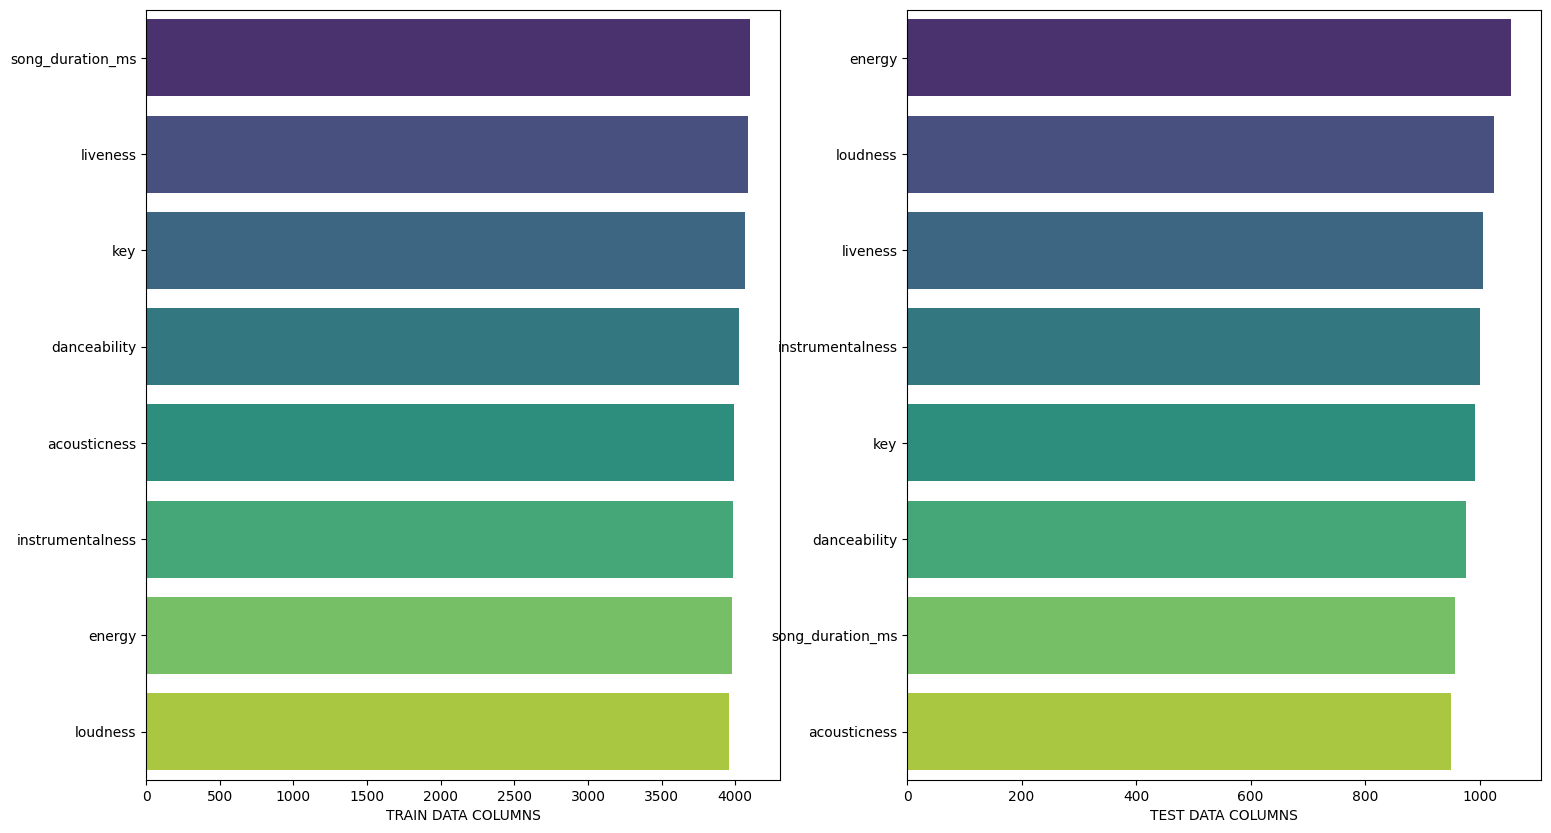

In [ ]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0 ,ascending = False)[:-5]
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-6]
fig, axes = plt.subplots(1,2, figsize=(18,10))
sns.barplot( y =test_null.index ,  x  = test_null[0] ,ax = axes[1] ,palette = "viridis")
sns.barplot( y =train_null.index ,  x  = train_null[0],ax = axes[0],palette = "viridis")
axes[0].set_xlabel("TRAIN DATA COLUMNS")
axes[1].set_xlabel("TEST DATA COLUMNS");

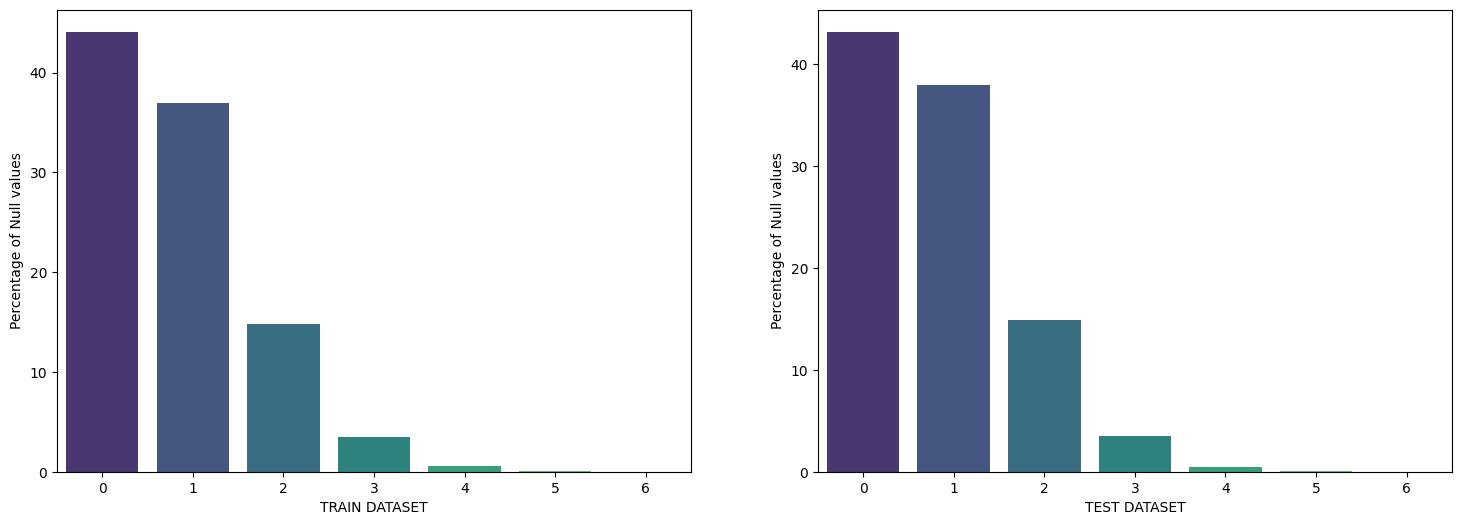

In [ ]:
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100
fig, axes = plt.subplots(1,2, figsize=(18,6))
sns.barplot( y =missing_train_row["count"] ,  x  = missing_train_row["no"],ax = axes[1] ,palette = "viridis")
sns.barplot( y =missing_test_row["count"] ,  x  = missing_test_row["no"],ax = axes[0] ,palette = "viridis")
axes[0].set_ylabel("Percentage of Null values")
axes[1].set_ylabel("Percentage of Null values")
axes[0].set_xlabel("TRAIN DATASET")
axes[1].set_xlabel("TEST DATASET");

Total number of features: 13
Number of categorical features: 3
Number of continuos features: 10


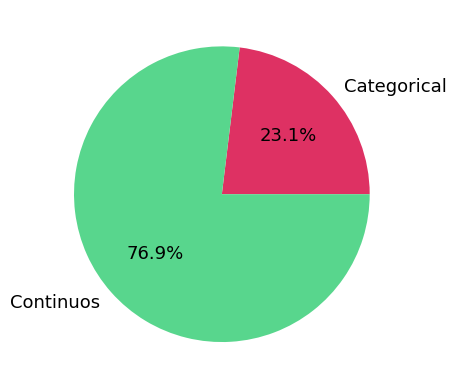

In [ ]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)

cat_features = [col for col in FEATURES if df[col].nunique() < 15]
cont_features = [col for col in FEATURES if df[col].nunique() >= 15]

del df
print(f'Total number of features: {len(FEATURES)}')
print(f'\033[92mNumber of categorical features: {len(cat_features)}')
print(f'\033[96mNumber of continuos features: {len(cont_features)}')

plt.pie([len(cat_features), len(cont_features)],
        labels=['Categorical', 'Continuos'],
        colors=['#DE3163', '#58D68D'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()

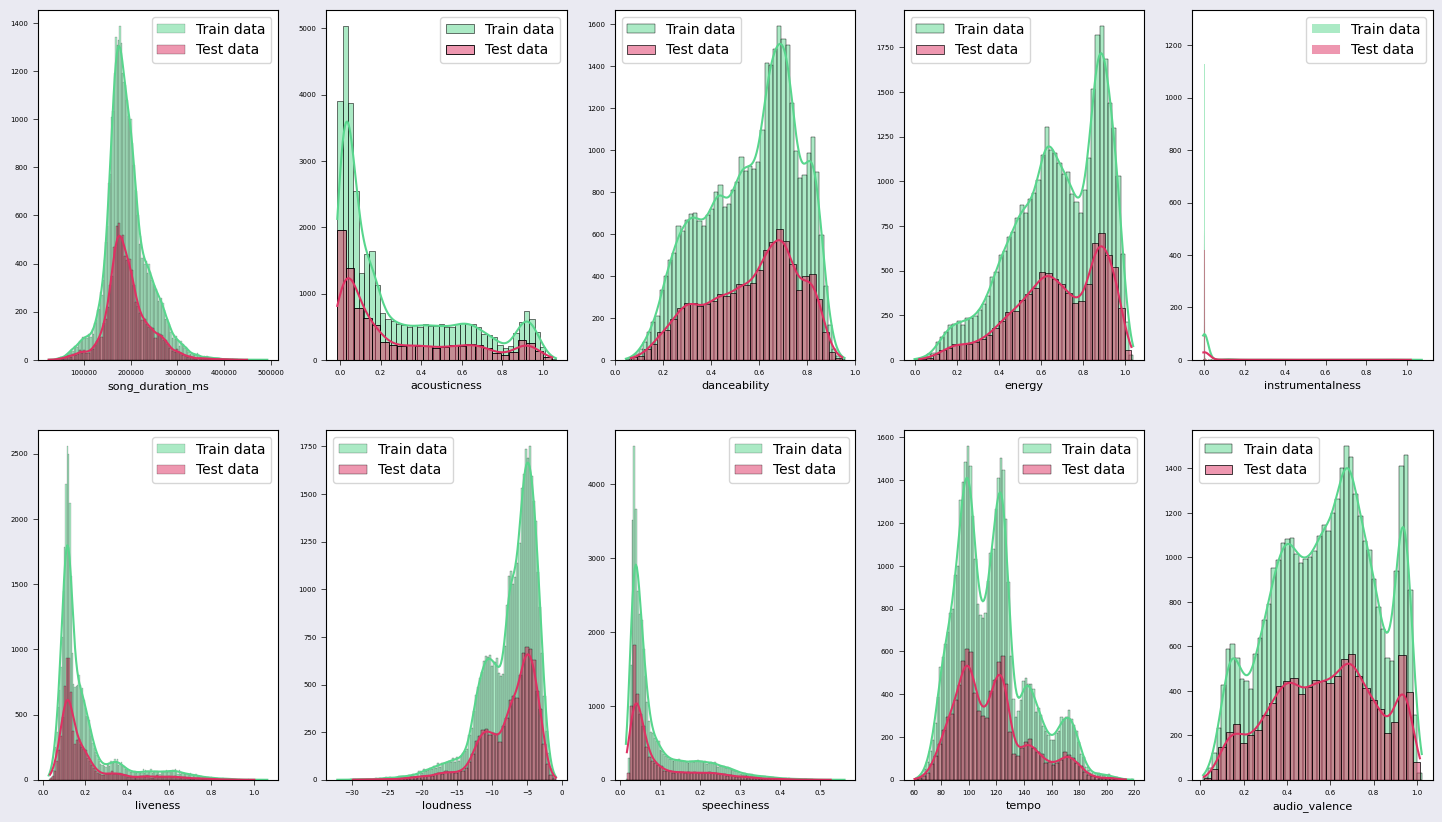

In [ ]:
from math import ceil
ncols = 5

nrows =ceil (len(cont_features) / ncols )

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = cont_features[r*ncols+c]
        sns.histplot(x=train[col], ax=axes[r, c], color='#58D68D', label='Train data' , fill =True , kde = True)
        sns.histplot(x=test[col], ax=axes[r, c], color='#DE3163', label='Test data', fill =True, kde = True)
        axes[r,c].legend()
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8)
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

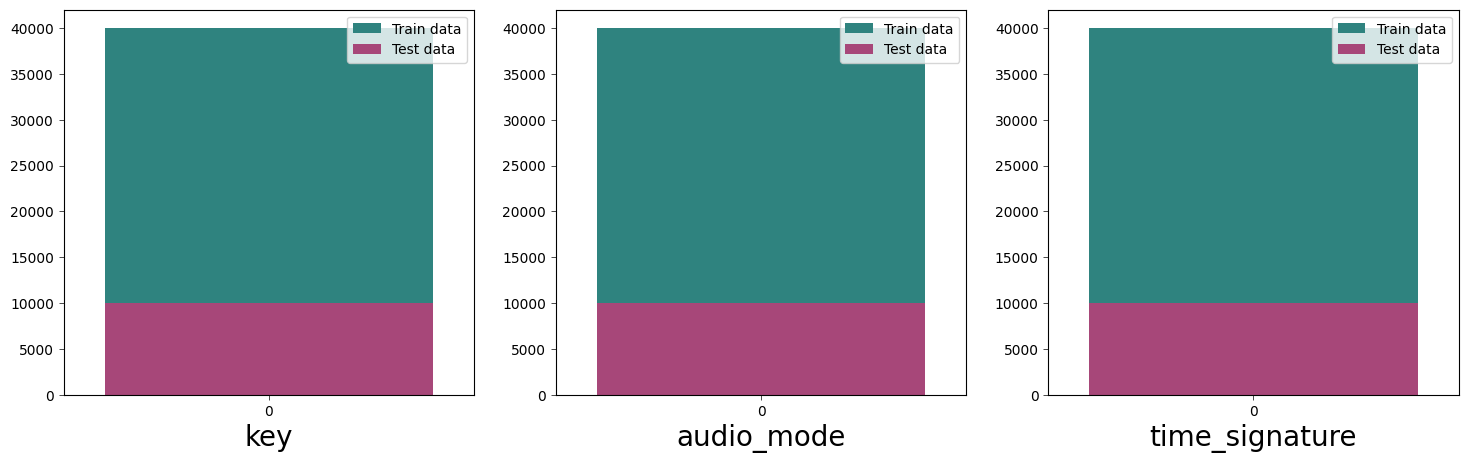

In [ ]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 3
    nrows = 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[c]
            sns.countplot(train[col],ax = axes[c] ,palette = "viridis", label='Train data')
            sns.countplot(test[col],ax = axes[c] ,palette = "magma", label='Test data')
            axes[c].legend()
            axes[c].set_ylabel('')
            axes[c].set_xlabel(col, fontsize=20)
            axes[c].tick_params(labelsize=10, width=0.5)
            axes[c].xaxis.offsetText.set_fontsize(4)
            axes[c].yaxis.offsetText.set_fontsize(4)
    plt.show()

In [ ]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df,
             x = TARGET,
             y = 'count' ,
             color = "count",
             color_continuous_scale="Emrld")
fig.update_layout(template = "plotly_white")
print("\033[94mPercentage of song_popularity = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of song_popularity = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
fig.show()

Percentage of song_popularity = 0: 63.56 %
Percentage of song_popularity = 1: 36.44 %


##  missing values

In [ ]:
train_X = train.iloc[:, :-1]
train_y = train.loc[:,'song_popularity']

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')

In [ ]:
cols = train_X.columns
train_X= pd.DataFrame(imp.fit_transform(train_X), columns = cols)
test = pd.DataFrame(imp.transform(test), columns = cols)

In [ ]:
train_X.isna().sum()

song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

array([[<Axes: title={'center': 'song_duration_ms'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'loudness'}>],
       [<Axes: title={'center': 'audio_mode'}>,
        <Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'time_signature'}>],
       [<Axes: title={'center': 'audio_valence'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

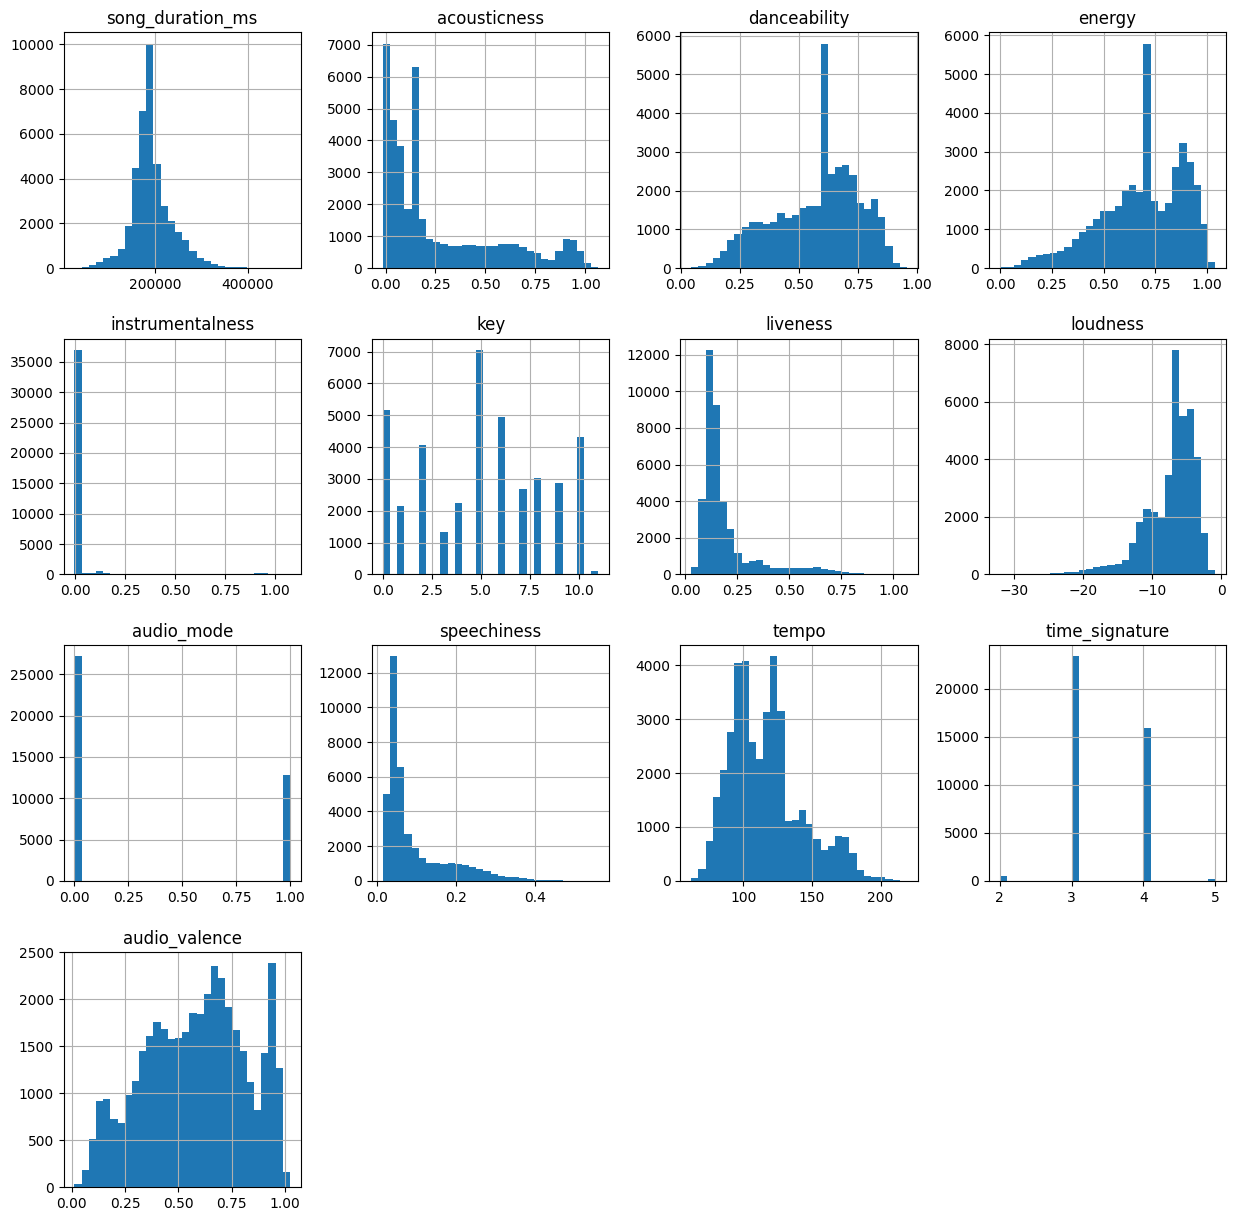

In [ ]:
train_X.hist(bins=30, figsize=(15, 15))


## Visualizing data

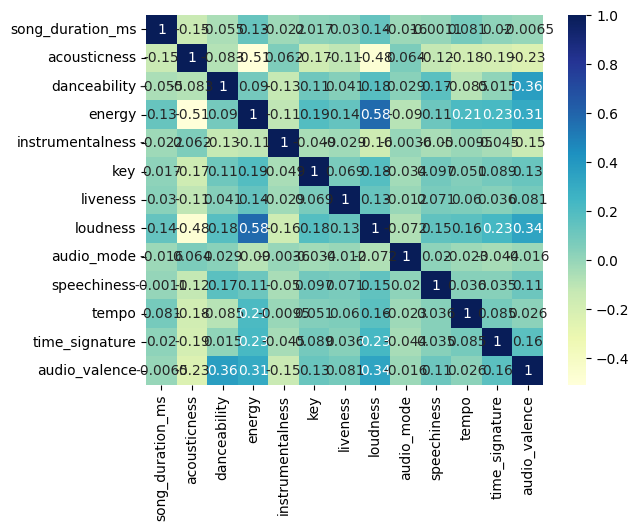

In [ ]:
corr = train_X.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.mask(mask)

# p
# plotting correlation heatmap
dataplot = sns.heatmap(train_X.corr(), cmap="YlGnBu", annot=True)

# displaying hea

## Separating the categorical and numeric columns



In [ ]:
train_cat = train_X.loc[:, ['key', 'audio_mode']]
test_cat = test.loc[:, ['key', 'audio_mode']]
train_cat.head()

,key,audio_mode
0,10.000000,0.000000
1,8.000000,1.000000
2,5.000000,0.000000
3,0.000000,0.000000
4,10.000000,0.000000


In [ ]:
train_num = train_X.drop(['key', 'audio_mode'], axis = 1)
test_num = test.drop(['key', 'audio_mode'], axis = 1)
train_num.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,audio_valence
0,212990.000000,0.642286,0.856520,0.707073,0.002001,0.135945,-5.619088,0.082570,158.386236,4.000000,0.734642
1,186660.000000,0.054866,0.733289,0.835545,0.000996,0.436428,-5.236965,0.127358,102.752988,3.000000,0.711531
2,193213.000000,0.140532,0.188387,0.783524,-0.002694,0.170499,-4.951759,0.052282,178.685791,3.000000,0.425536
3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.094805,-7.893694,0.035618,128.715630,3.000000,0.453597
4,165969.000000,0.493017,0.608234,0.740982,0.002033,0.094891,-2.684095,0.050746,121.928157,4.000000,0.741311


## Transform features by scaling each feature to a given range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(train_num)
train_num = pd.DataFrame(scaler.transform(train_num), columns = train_num.columns)
test_num = pd.DataFrame(scaler.transform(test_num), columns = test_num.columns)
train_num.head()


,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,audio_valence
0,0.401989,0.607912,0.889823,0.680564,0.005926,0.104199,0.848218,0.123707,0.613149,0.666667,0.714697
1,0.345488,0.063417,0.754874,0.803926,0.004995,0.393834,0.860450,0.205786,0.259040,0.333333,0.691796
2,0.359550,0.142824,0.158159,0.753974,0.001578,0.137505,0.869579,0.068202,0.742357,0.333333,0.408397
3,0.481178,0.465512,0.592741,0.532317,0.004636,0.064544,0.775409,0.037664,0.424294,0.333333,0.436204
4,0.301088,0.469551,0.617928,0.713124,0.005956,0.064627,0.942167,0.065389,0.381091,0.666667,0.721306


array([[<Axes: title={'center': 'song_duration_ms'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'tempo'}>],
       [<Axes: title={'center': 'time_signature'}>,
        <Axes: title={'center': 'audio_valence'}>, <Axes: >]],
      dtype=object)

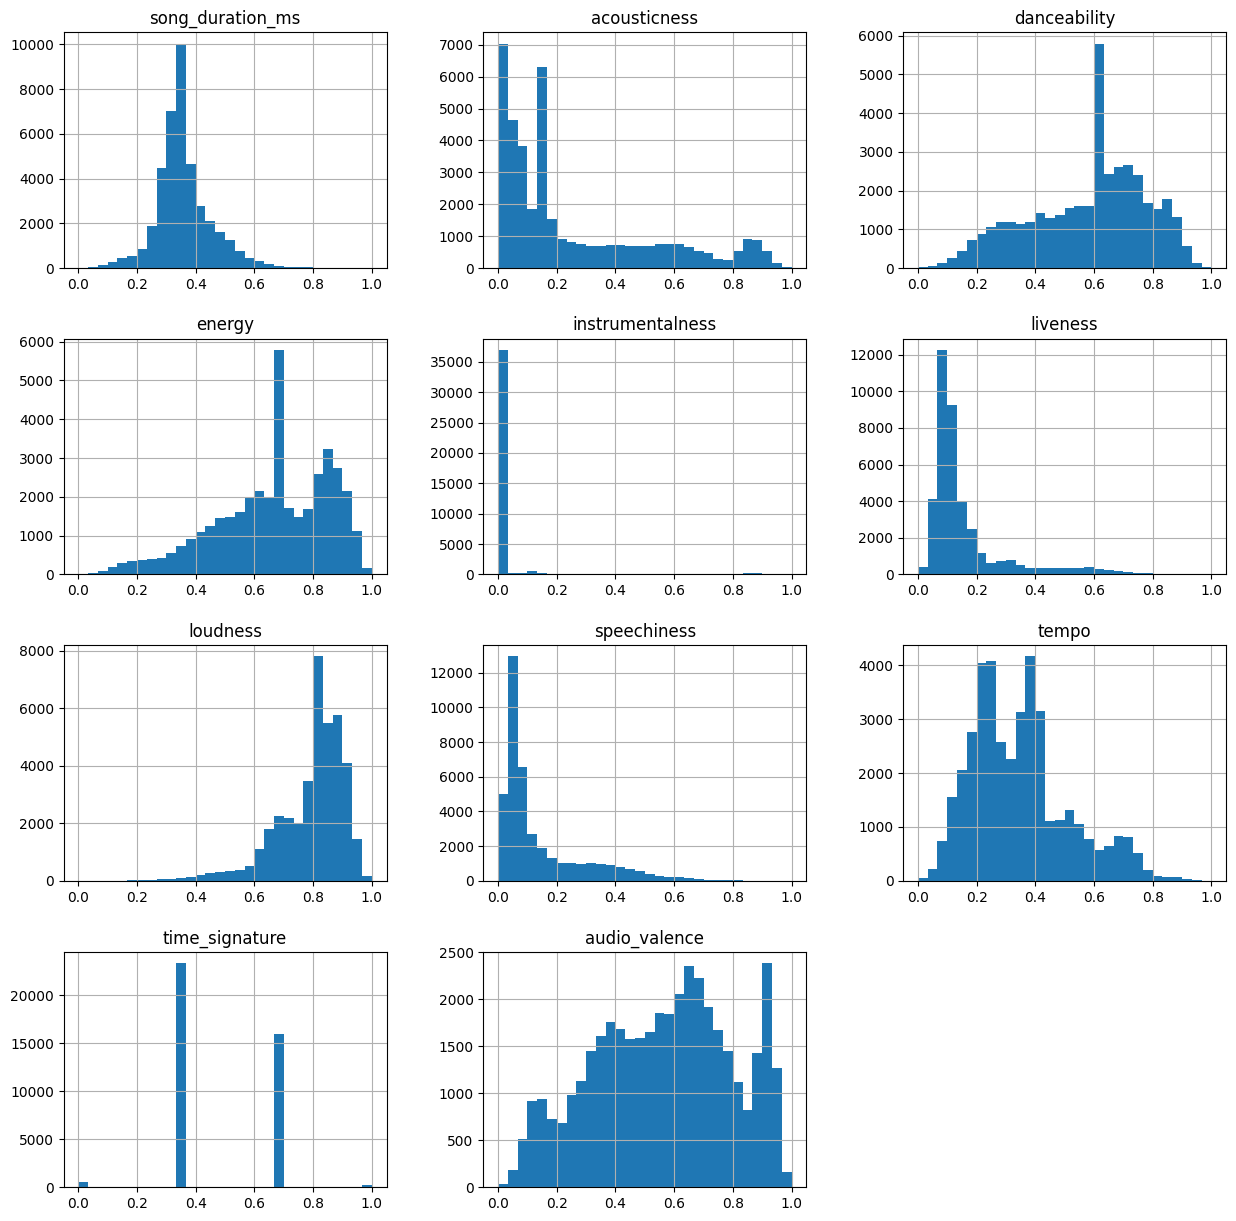

In [ ]:
train_num.hist(bins=30, figsize=(15, 15))


## variable transformations


One Hot Encoding for categorical variables
Log transformations for skewed numeric data

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

logtransformer = FunctionTransformer(np.log, validate=True)
cuberoottransformer = FunctionTransformer(np.cbrt, validate = True)

ct = ColumnTransformer(transformers=[
    ("LogTransformation", logtransformer, [1,5,7]),
#     ("CubeRootTransformation", cuberoottransformer, [3, 6])
])
ct.fit(train_num)
X = pd.DataFrame(ct.transform(train_num), columns = [
    'acousticness' ,'liveness', 'speechiness',
#     'energy' ,'loudness'
]).replace([-np.inf, np.inf], 0)


test_X = pd.DataFrame(ct.transform(test_num), columns = [
    'acousticness' ,'liveness', 'speechiness',
#     'energy' ,'loudness'
]).replace([-np.inf, np.inf], 0)

In [ ]:
train_num['speechiness'] = X['speechiness']
train_num['liveness'] = X['liveness']

test_num['speechiness'] = test_X['speechiness']
test_num['liveness'] = test_X['liveness']

array([[<Axes: title={'center': 'song_duration_ms'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'tempo'}>],
       [<Axes: title={'center': 'time_signature'}>,
        <Axes: title={'center': 'audio_valence'}>, <Axes: >]],
      dtype=object)

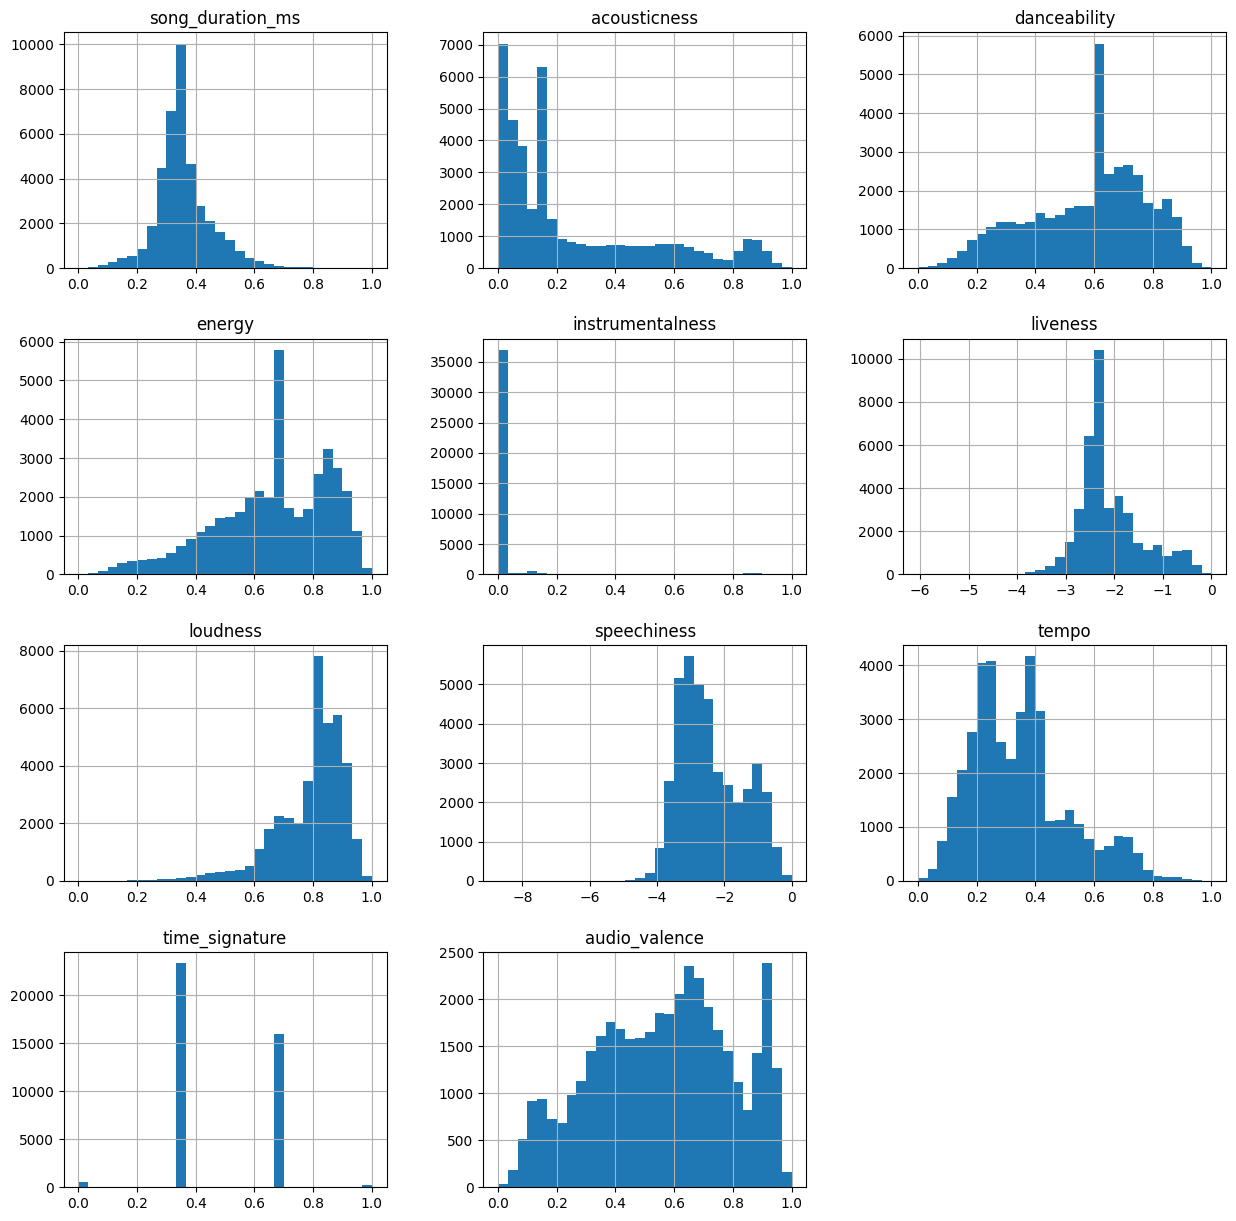

In [ ]:
train_num.hist(bins=30, figsize=(15, 15))


## Encoding Categorical variables



In [ ]:
train_cat['key'] = train_cat['key'].apply(np.ceil).astype(str)
test_cat['key'] = test_cat['key'].apply(np.ceil).astype(str)
train_cat['key'].value_counts()

5.0     7050
0.0     5175
6.0     4949
10.0    4302
2.0     4080
8.0     3028
9.0     2881
7.0     2690
4.0     2239
1.0     2143
3.0     1346
11.0     117
Name: key, dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

catencode = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder = 'passthrough')
train_cat = pd.DataFrame(catencode.fit_transform(train_cat).todense())
test_cat = pd.DataFrame(catencode.transform(test_cat).todense())
train_cat.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
final_X = pd.concat([train_num, train_cat], axis = 1)
final_test_X = pd.concat([test_num, test_cat], axis = 1)

In [ ]:
final_X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_duration_ms  40000 non-null  float64
 1   acousticness      40000 non-null  float64
 2   danceability      40000 non-null  float64
 3   energy            40000 non-null  float64
 4   instrumentalness  40000 non-null  float64
 5   liveness          40000 non-null  float64
 6   loudness          40000 non-null  float64
 7   speechiness       40000 non-null  float64
 8   tempo             40000 non-null  float64
 9   time_signature    40000 non-null  float64
 10  audio_valence     40000 non-null  float64
 11  0                 40000 non-null  float64
 12  1                 40000 non-null  float64
 13  2                 40000 non-null  float64
 14  3                 40000 non-null  float64
 15  4                 40000 non-null  float64
 16  5                 40000 non-null  float6

In [ ]:
final_X.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,audio_valence,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.401989,0.607912,0.889823,0.680564,0.005926,-2.261450,0.848218,-2.089839,0.613149,0.666667,0.714697,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.345488,0.063417,0.754874,0.803926,0.004995,-0.931826,0.860450,-1.580921,0.259040,0.333333,0.691796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
2,0.359550,0.142824,0.158159,0.753974,0.001578,-1.984093,0.869579,-2.685275,0.742357,0.333333,0.408397,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.481178,0.465512,0.592741,0.532317,0.004636,-2.740401,0.775409,-3.279038,0.424294,0.333333,0.436204,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.301088,0.469551,0.617928,0.713124,0.005956,-2.739118,0.942167,-2.727408,0.381091,0.666667,0.721306,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
final_X.columns = final_X.columns.astype(str)


In [ ]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# reg = LinearRegression().fit(final_X, train_y)
# pred_y = reg.predict(final_X)
# r2 = r2_score(train_y, pred_y)
# print("\033[92mR2 Score: {:.2f}".format(r2))

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,
                 learning_rate=0.07,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=75,
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42,
                 random_state=42)

xgb_model.fit(final_X, train_y)
pred_y = xgb_model.predict(final_X)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(train_y, pred_y)
metrics.auc(fpr, tpr)

0.7164900507480939

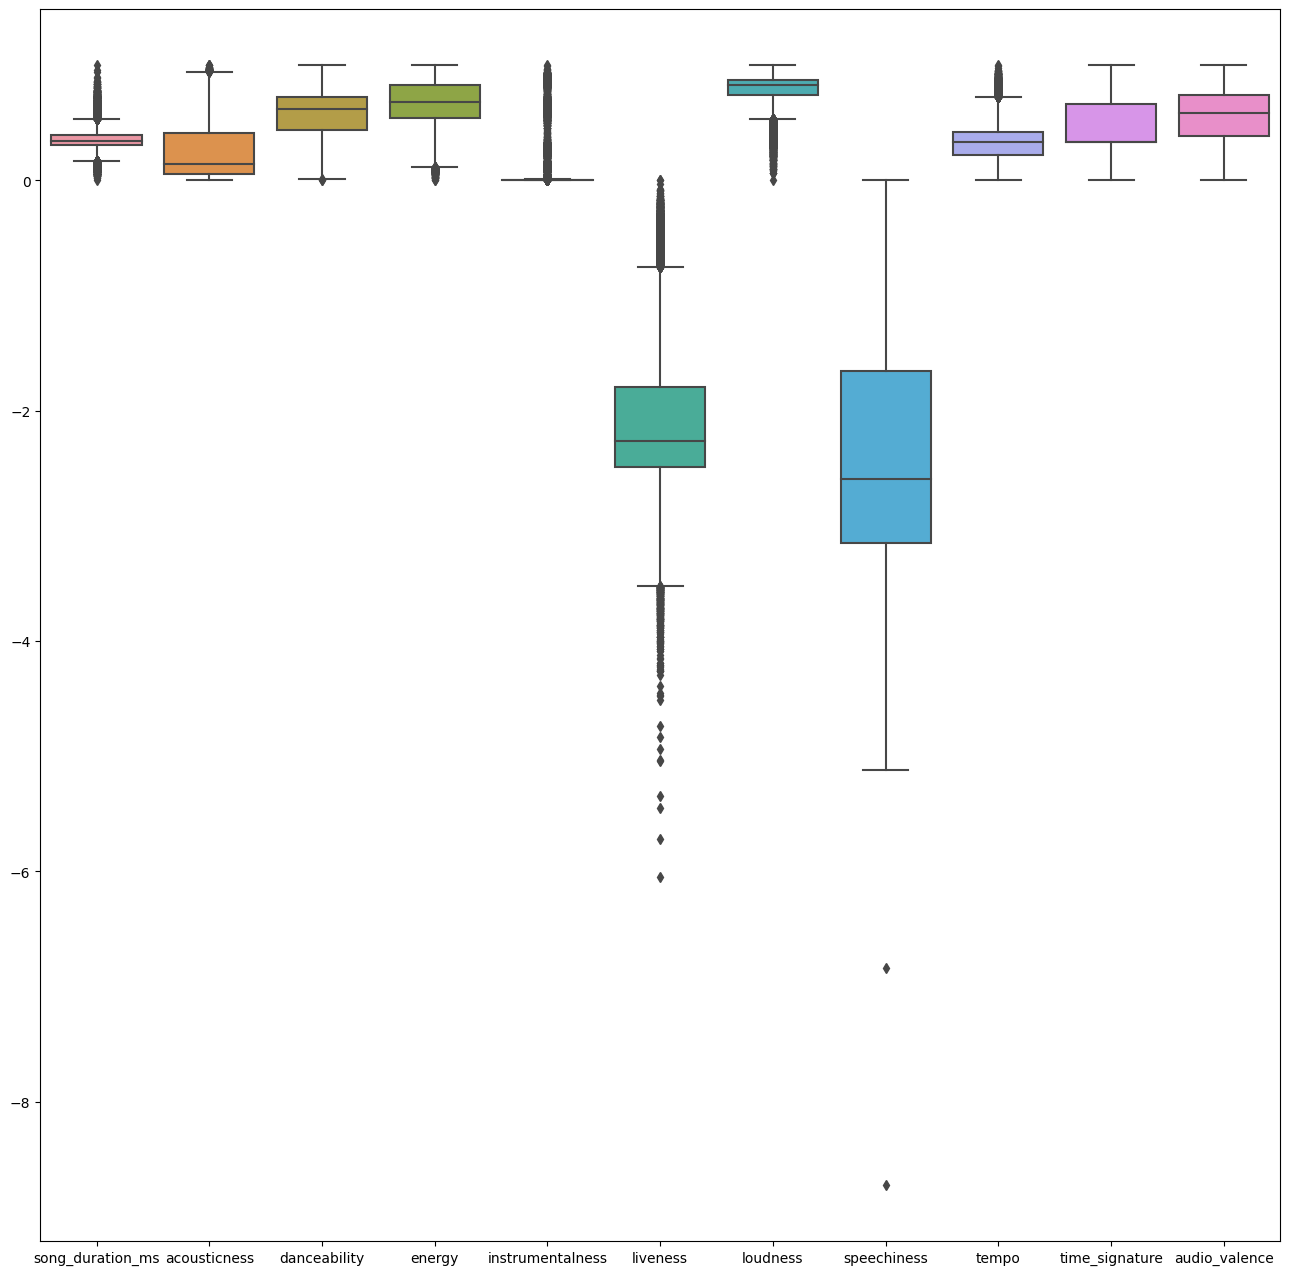

In [ ]:
plt.figure(figsize = (16,16))
sns.boxplot(data=train_num)
plt.show()

sources:
1-https://www.kaggle.com/code/priyanagda/eda-linear-regression

2-https://www.kaggle.com/code/odins0n/song-popularity-prediction-eda-modelling#EDA